# DQN with rated memory replay

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
import numpy as np

state = env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action) # take a random action
    batch.append([state, action, next_state, reward, float(done)])
    #     print('state, action, reward, done, info:', 
    #           state, action, reward, done, info)
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][0].shape

([array([-0.04614254, -0.01506811, -0.02828059,  0.03514623]),
  0,
  array([-0.0464439 , -0.20977333, -0.02757766,  0.3187739 ]),
  1.0,
  0.0],
 (4,))

In [5]:
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 float64
1 0
2
1.0 1.0
2.296781374484523 -2.4668174457845167


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [8]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
def model_loss(states, actions, targetQs, action_size, hidden_size):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    #Qs = tf.reduce_max(actions_logits, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [10]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
def sample(batch_size, ListArr):
    idx = np.random.choice(np.arange(len(ListArr)), 
                           size=batch_size, 
                           replace=True)
    return [ListArr[ii] for ii in idx]

In [13]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), 
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [15]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 24*2             # number of units in each Q-network hidden layer
learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size
gamma = 0.99                   # future reward discount

In [16]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initializing the memory with the pool of random exploration of the env.
goal = 500 # env-based, the total reward required for reaching the goal G
state = env.reset() # env-based
total_reward = 0 # episode R
num_step = 0 # episode steps/ length based on number of steps
for _ in range(memory_size):
    action = env.action_space.sample() # exploring the env action space/ random action/ explore
    next_state, reward, done, _ = env.step(action) # exploring the env state, reward, and done/end
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward # R += r
    state = next_state # update the state for next episode
    if done is True: # end of this episode
        state = env.reset() # reset for next episode
        rate = total_reward/goal # the actual sucess rate of the played sequence
        total_reward = 0 # reset for next episode
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                memory.buffer[-1-idx][5] = rate # rate each SA pair
        num_step = 0 # reset for the next episode

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state

            # Rating the last played episode
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair
                        
            # Rating and training the memory
            #rates = np.array(memory.buffer)[:, 5]
            #rated_mem = np.array(memory.buffer)[rates >= (max(rates)*0.1)]
            #rated_mem = np.array(memory.buffer)
            #batch = sample(ListArr=rated_mem, batch_size=batch_size)
            batch = sample(ListArr=memory.buffer, batch_size=batch_size)
            rates = np.array([each[5] for each in batch])
            states = np.array([each[0] for each in batch])[rates >= (max(rates)*0.1)]
            actions = np.array([each[1] for each in batch])[rates >= (max(rates)*0.1)]
            next_states = np.array([each[2] for each in batch])[rates >= (max(rates)*0.1)]
            rewards = np.array([each[3] for each in batch])[rates >= (max(rates)*0.1)]
            dones = np.array([each[4] for each in batch])[rates >= (max(rates)*0.1)]
            #rates = np.array([each[5] for each in batch])
            #nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0 rate:0.0420 loss:0.9962 exploreP:0.9979
Episode:1 meanR:19.5000 R:18.0 rate:0.0360 loss:1.0013 exploreP:0.9961
Episode:2 meanR:20.3333 R:22.0 rate:0.0440 loss:1.0146 exploreP:0.9940
Episode:3 meanR:20.0000 R:19.0 rate:0.0380 loss:1.0440 exploreP:0.9921
Episode:4 meanR:19.6000 R:18.0 rate:0.0360 loss:1.0671 exploreP:0.9903
Episode:5 meanR:18.5000 R:13.0 rate:0.0260 loss:1.0828 exploreP:0.9891
Episode:6 meanR:18.4286 R:18.0 rate:0.0360 loss:1.0859 exploreP:0.9873
Episode:7 meanR:17.7500 R:13.0 rate:0.0260 loss:1.0896 exploreP:0.9860
Episode:8 meanR:17.2222 R:13.0 rate:0.0260 loss:1.1062 exploreP:0.9848
Episode:9 meanR:17.7000 R:22.0 rate:0.0440 loss:1.1211 exploreP:0.9826
Episode:10 meanR:18.8182 R:30.0 rate:0.0600 loss:1.1419 exploreP:0.9797
Episode:11 meanR:19.1667 R:23.0 rate:0.0460 loss:1.1798 exploreP:0.9775
Episode:12 meanR:18.5385 R:11.0 rate:0.0220 loss:1.2028 exploreP:0.9764
Episode:13 meanR:18.5000 R:18.0 rate:0.0360 loss:1.2504 exploreP:0.9747
Ep

Episode:114 meanR:22.0200 R:51.0 rate:0.1020 loss:59.4320 exploreP:0.7832
Episode:115 meanR:21.9700 R:16.0 rate:0.0320 loss:62.7774 exploreP:0.7819
Episode:116 meanR:21.9400 R:18.0 rate:0.0360 loss:52.6597 exploreP:0.7806
Episode:117 meanR:21.8100 R:10.0 rate:0.0200 loss:50.2963 exploreP:0.7798
Episode:118 meanR:21.8000 R:13.0 rate:0.0260 loss:48.7943 exploreP:0.7788
Episode:119 meanR:21.6800 R:12.0 rate:0.0240 loss:54.8435 exploreP:0.7779
Episode:120 meanR:21.6600 R:14.0 rate:0.0280 loss:57.5740 exploreP:0.7768
Episode:121 meanR:21.5800 R:13.0 rate:0.0260 loss:55.8540 exploreP:0.7758
Episode:122 meanR:21.7000 R:27.0 rate:0.0540 loss:51.2273 exploreP:0.7737
Episode:123 meanR:21.4600 R:23.0 rate:0.0460 loss:59.0369 exploreP:0.7720
Episode:124 meanR:21.1500 R:14.0 rate:0.0280 loss:45.4805 exploreP:0.7709
Episode:125 meanR:21.1100 R:12.0 rate:0.0240 loss:39.5086 exploreP:0.7700
Episode:126 meanR:21.1800 R:24.0 rate:0.0480 loss:43.7610 exploreP:0.7682
Episode:127 meanR:21.1300 R:13.0 rate:

Episode:225 meanR:34.9900 R:23.0 rate:0.0460 loss:32.3538 exploreP:0.5456
Episode:226 meanR:35.8900 R:114.0 rate:0.2280 loss:37.9309 exploreP:0.5395
Episode:227 meanR:36.1000 R:34.0 rate:0.0680 loss:34.3856 exploreP:0.5377
Episode:228 meanR:36.8400 R:87.0 rate:0.1740 loss:39.7266 exploreP:0.5332
Episode:229 meanR:37.5400 R:82.0 rate:0.1640 loss:43.1936 exploreP:0.5289
Episode:230 meanR:37.6800 R:50.0 rate:0.1000 loss:40.6173 exploreP:0.5263
Episode:231 meanR:38.0700 R:52.0 rate:0.1040 loss:39.3081 exploreP:0.5236
Episode:232 meanR:38.5300 R:58.0 rate:0.1160 loss:43.0000 exploreP:0.5207
Episode:233 meanR:39.1200 R:71.0 rate:0.1420 loss:47.8724 exploreP:0.5170
Episode:234 meanR:39.4800 R:75.0 rate:0.1500 loss:47.7616 exploreP:0.5133
Episode:235 meanR:39.4100 R:13.0 rate:0.0260 loss:39.9653 exploreP:0.5126
Episode:236 meanR:40.9000 R:177.0 rate:0.3540 loss:48.0542 exploreP:0.5038
Episode:237 meanR:41.7100 R:106.0 rate:0.2120 loss:47.6660 exploreP:0.4986
Episode:238 meanR:42.3200 R:83.0 ra

Episode:334 meanR:140.5000 R:272.0 rate:0.5440 loss:259.7885 exploreP:0.1335
Episode:335 meanR:144.7300 R:436.0 rate:0.8720 loss:270.7763 exploreP:0.1282
Episode:336 meanR:146.0600 R:310.0 rate:0.6200 loss:280.6041 exploreP:0.1246
Episode:337 meanR:147.6500 R:265.0 rate:0.5300 loss:250.9721 exploreP:0.1216
Episode:338 meanR:149.3900 R:257.0 rate:0.5140 loss:219.7869 exploreP:0.1188
Episode:339 meanR:150.1300 R:225.0 rate:0.4500 loss:194.1490 exploreP:0.1164
Episode:340 meanR:151.4300 R:228.0 rate:0.4560 loss:249.6533 exploreP:0.1140
Episode:341 meanR:153.0300 R:227.0 rate:0.4540 loss:263.9418 exploreP:0.1116
Episode:342 meanR:154.3400 R:212.0 rate:0.4240 loss:246.4753 exploreP:0.1095
Episode:343 meanR:155.8400 R:222.0 rate:0.4440 loss:232.6557 exploreP:0.1073
Episode:344 meanR:157.8900 R:298.0 rate:0.5960 loss:256.4047 exploreP:0.1045
Episode:345 meanR:159.3900 R:198.0 rate:0.3960 loss:240.8142 exploreP:0.1026
Episode:346 meanR:163.1100 R:426.0 rate:0.8520 loss:251.2836 exploreP:0.0987

Episode:440 meanR:287.4000 R:500.0 rate:1.0000 loss:24143.0762 exploreP:0.0159
Episode:441 meanR:290.1300 R:500.0 rate:1.0000 loss:24528.9004 exploreP:0.0156
Episode:442 meanR:293.0100 R:500.0 rate:1.0000 loss:25797.9902 exploreP:0.0153
Episode:443 meanR:295.7900 R:500.0 rate:1.0000 loss:26182.4316 exploreP:0.0151
Episode:444 meanR:297.8100 R:500.0 rate:1.0000 loss:26326.7754 exploreP:0.0148
Episode:445 meanR:300.8300 R:500.0 rate:1.0000 loss:24712.5918 exploreP:0.0146
Episode:446 meanR:301.5700 R:500.0 rate:1.0000 loss:25996.3633 exploreP:0.0143
Episode:447 meanR:303.7600 R:500.0 rate:1.0000 loss:25987.6445 exploreP:0.0141
Episode:448 meanR:305.5300 R:500.0 rate:1.0000 loss:24676.4082 exploreP:0.0139
Episode:449 meanR:308.1300 R:500.0 rate:1.0000 loss:24026.1094 exploreP:0.0137
Episode:450 meanR:311.2400 R:500.0 rate:1.0000 loss:25059.5195 exploreP:0.0136
Episode:451 meanR:312.4400 R:500.0 rate:1.0000 loss:23116.3516 exploreP:0.0134
Episode:452 meanR:315.5700 R:500.0 rate:1.0000 loss:

Episode:544 meanR:498.1800 R:500.0 rate:1.0000 loss:44379.5742 exploreP:0.0100
Episode:545 meanR:498.1800 R:500.0 rate:1.0000 loss:46621.4258 exploreP:0.0100
Episode:546 meanR:498.1800 R:500.0 rate:1.0000 loss:44514.2578 exploreP:0.0100
Episode:547 meanR:498.1800 R:500.0 rate:1.0000 loss:46095.6016 exploreP:0.0100
Episode:548 meanR:498.1800 R:500.0 rate:1.0000 loss:47308.6641 exploreP:0.0100
Episode:549 meanR:498.1800 R:500.0 rate:1.0000 loss:49747.6367 exploreP:0.0100
Episode:550 meanR:498.1800 R:500.0 rate:1.0000 loss:52775.0391 exploreP:0.0100
Episode:551 meanR:498.1800 R:500.0 rate:1.0000 loss:52271.6094 exploreP:0.0100
Episode:552 meanR:498.1800 R:500.0 rate:1.0000 loss:56494.8203 exploreP:0.0100
Episode:553 meanR:498.1800 R:500.0 rate:1.0000 loss:61410.3672 exploreP:0.0100
Episode:554 meanR:498.1800 R:500.0 rate:1.0000 loss:61183.7930 exploreP:0.0100
Episode:555 meanR:498.1800 R:500.0 rate:1.0000 loss:59939.3398 exploreP:0.0100
Episode:556 meanR:498.1800 R:500.0 rate:1.0000 loss:

Episode:654 meanR:275.0000 R:12.0 rate:0.0240 loss:25867.9902 exploreP:0.0100
Episode:655 meanR:270.1100 R:11.0 rate:0.0220 loss:26067.6895 exploreP:0.0100
Episode:656 meanR:265.2100 R:10.0 rate:0.0200 loss:31709.5156 exploreP:0.0100
Episode:657 meanR:260.3300 R:12.0 rate:0.0240 loss:14247.9443 exploreP:0.0100
Episode:658 meanR:255.4300 R:10.0 rate:0.0200 loss:16867.4004 exploreP:0.0100
Episode:659 meanR:250.5300 R:10.0 rate:0.0200 loss:11118.7324 exploreP:0.0100
Episode:660 meanR:245.6500 R:12.0 rate:0.0240 loss:31916.0488 exploreP:0.0100
Episode:661 meanR:240.7700 R:12.0 rate:0.0240 loss:18627.4512 exploreP:0.0100
Episode:662 meanR:235.8800 R:11.0 rate:0.0220 loss:20050.0801 exploreP:0.0100
Episode:663 meanR:230.9900 R:11.0 rate:0.0220 loss:12937.9678 exploreP:0.0100
Episode:664 meanR:226.1100 R:12.0 rate:0.0240 loss:26665.9160 exploreP:0.0100
Episode:665 meanR:221.2300 R:12.0 rate:0.0240 loss:15218.1982 exploreP:0.0100
Episode:666 meanR:216.3500 R:12.0 rate:0.0240 loss:38822.7930 ex

Episode:762 meanR:11.4500 R:10.0 rate:0.0200 loss:48635.5234 exploreP:0.0100
Episode:763 meanR:11.4700 R:13.0 rate:0.0260 loss:101441.0781 exploreP:0.0100
Episode:764 meanR:11.4600 R:11.0 rate:0.0220 loss:69759.7344 exploreP:0.0100
Episode:765 meanR:11.4600 R:12.0 rate:0.0240 loss:60578.1680 exploreP:0.0100
Episode:766 meanR:11.4600 R:12.0 rate:0.0240 loss:74046.6094 exploreP:0.0100
Episode:767 meanR:11.4500 R:11.0 rate:0.0220 loss:94044.9766 exploreP:0.0100
Episode:768 meanR:11.4600 R:12.0 rate:0.0240 loss:84523.3984 exploreP:0.0100
Episode:769 meanR:11.4800 R:12.0 rate:0.0240 loss:85182.5703 exploreP:0.0100
Episode:770 meanR:11.4900 R:11.0 rate:0.0220 loss:92170.6797 exploreP:0.0100
Episode:771 meanR:11.5100 R:12.0 rate:0.0240 loss:87251.7422 exploreP:0.0100
Episode:772 meanR:11.4900 R:11.0 rate:0.0220 loss:82212.3203 exploreP:0.0100
Episode:773 meanR:11.4800 R:11.0 rate:0.0220 loss:60739.3086 exploreP:0.0100
Episode:774 meanR:11.4700 R:10.0 rate:0.0200 loss:88365.8438 exploreP:0.010

Episode:871 meanR:10.9200 R:10.0 rate:0.0200 loss:151734.1562 exploreP:0.0100
Episode:872 meanR:10.9200 R:11.0 rate:0.0220 loss:126273.9922 exploreP:0.0100
Episode:873 meanR:10.9100 R:10.0 rate:0.0200 loss:142991.4062 exploreP:0.0100
Episode:874 meanR:10.9200 R:11.0 rate:0.0220 loss:194737.1406 exploreP:0.0100
Episode:875 meanR:10.9100 R:11.0 rate:0.0220 loss:180159.7500 exploreP:0.0100
Episode:876 meanR:10.8900 R:11.0 rate:0.0220 loss:138286.3281 exploreP:0.0100
Episode:877 meanR:10.8800 R:11.0 rate:0.0220 loss:162669.9375 exploreP:0.0100
Episode:878 meanR:10.9000 R:12.0 rate:0.0240 loss:156818.8438 exploreP:0.0100
Episode:879 meanR:10.9000 R:11.0 rate:0.0220 loss:147933.1406 exploreP:0.0100
Episode:880 meanR:10.8900 R:10.0 rate:0.0200 loss:143440.9219 exploreP:0.0100
Episode:881 meanR:10.8900 R:11.0 rate:0.0220 loss:154956.6094 exploreP:0.0100
Episode:882 meanR:10.9000 R:11.0 rate:0.0220 loss:198233.9844 exploreP:0.0100
Episode:883 meanR:10.8900 R:10.0 rate:0.0200 loss:145270.0938 ex

Episode:980 meanR:10.0500 R:9.0 rate:0.0180 loss:373109.1250 exploreP:0.0100
Episode:981 meanR:10.0200 R:8.0 rate:0.0160 loss:429035.3438 exploreP:0.0100
Episode:982 meanR:10.0000 R:9.0 rate:0.0180 loss:387235.8438 exploreP:0.0100
Episode:983 meanR:10.0000 R:10.0 rate:0.0200 loss:396856.8438 exploreP:0.0100
Episode:984 meanR:9.9800 R:9.0 rate:0.0180 loss:472770.2812 exploreP:0.0100
Episode:985 meanR:9.9600 R:10.0 rate:0.0200 loss:352976.6250 exploreP:0.0100
Episode:986 meanR:9.9400 R:9.0 rate:0.0180 loss:379331.2812 exploreP:0.0100
Episode:987 meanR:9.9300 R:10.0 rate:0.0200 loss:445039.0938 exploreP:0.0100
Episode:988 meanR:9.9300 R:9.0 rate:0.0180 loss:427728.7188 exploreP:0.0100
Episode:989 meanR:9.9100 R:9.0 rate:0.0180 loss:381872.6562 exploreP:0.0100
Episode:990 meanR:9.8800 R:10.0 rate:0.0200 loss:317446.4062 exploreP:0.0100
Episode:991 meanR:9.8600 R:9.0 rate:0.0180 loss:422335.1562 exploreP:0.0100
Episode:992 meanR:9.8100 R:8.0 rate:0.0160 loss:284583.6250 exploreP:0.0100
Epis

Episode:1088 meanR:9.4600 R:11.0 rate:0.0220 loss:149459.2656 exploreP:0.0100
Episode:1089 meanR:9.4700 R:10.0 rate:0.0200 loss:123125.8516 exploreP:0.0100
Episode:1090 meanR:9.4600 R:9.0 rate:0.0180 loss:187400.9688 exploreP:0.0100
Episode:1091 meanR:9.4600 R:9.0 rate:0.0180 loss:117247.0547 exploreP:0.0100
Episode:1092 meanR:9.4700 R:9.0 rate:0.0180 loss:85365.8125 exploreP:0.0100
Episode:1093 meanR:9.4700 R:10.0 rate:0.0200 loss:124252.8281 exploreP:0.0100
Episode:1094 meanR:9.4800 R:10.0 rate:0.0200 loss:109350.2891 exploreP:0.0100
Episode:1095 meanR:9.4600 R:9.0 rate:0.0180 loss:140150.3594 exploreP:0.0100
Episode:1096 meanR:9.4600 R:9.0 rate:0.0180 loss:209802.0781 exploreP:0.0100
Episode:1097 meanR:9.4700 R:9.0 rate:0.0180 loss:138658.1094 exploreP:0.0100
Episode:1098 meanR:9.4900 R:11.0 rate:0.0220 loss:101390.9062 exploreP:0.0100
Episode:1099 meanR:9.4900 R:10.0 rate:0.0200 loss:83308.6172 exploreP:0.0100
Episode:1100 meanR:9.4800 R:8.0 rate:0.0160 loss:85907.2344 exploreP:0.0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

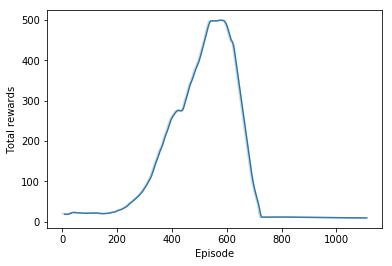

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

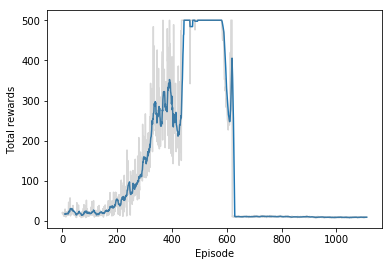

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

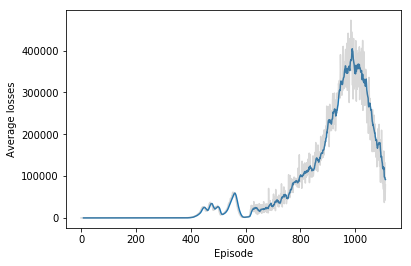

In [22]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.